In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

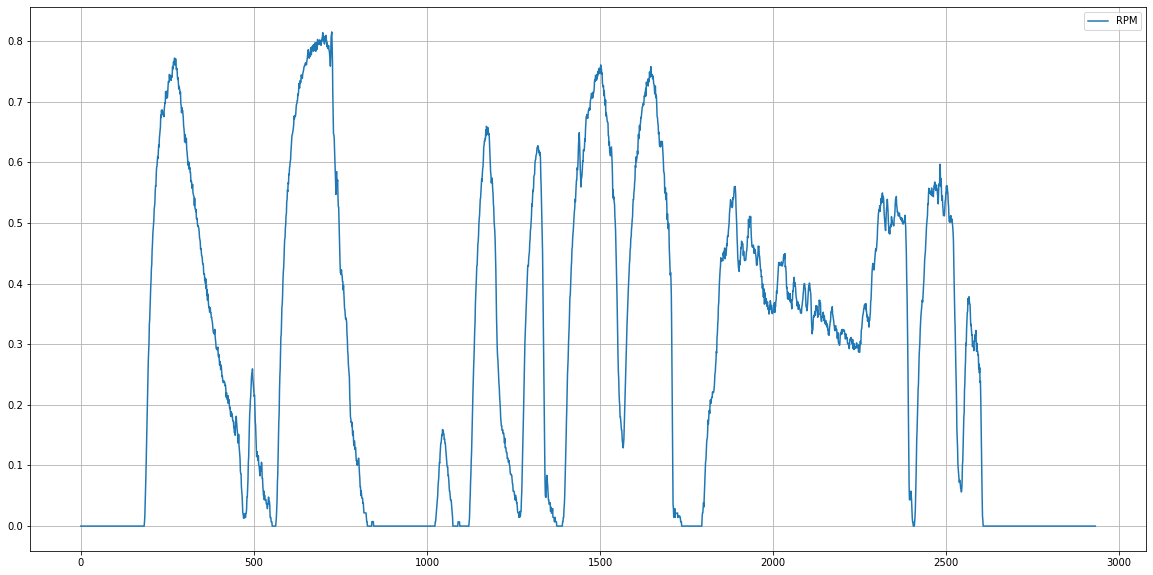

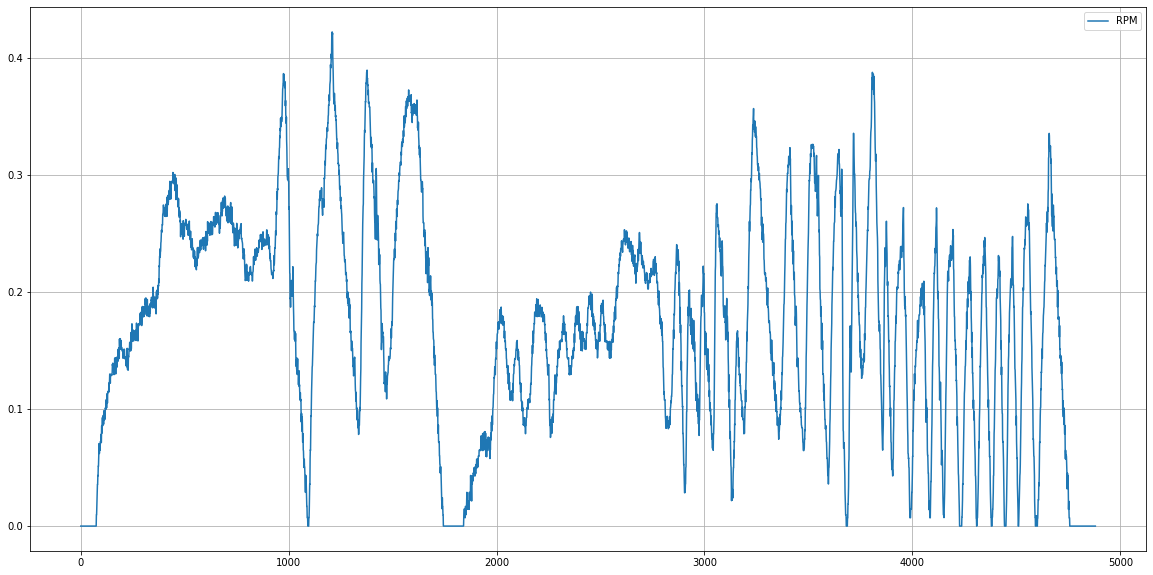

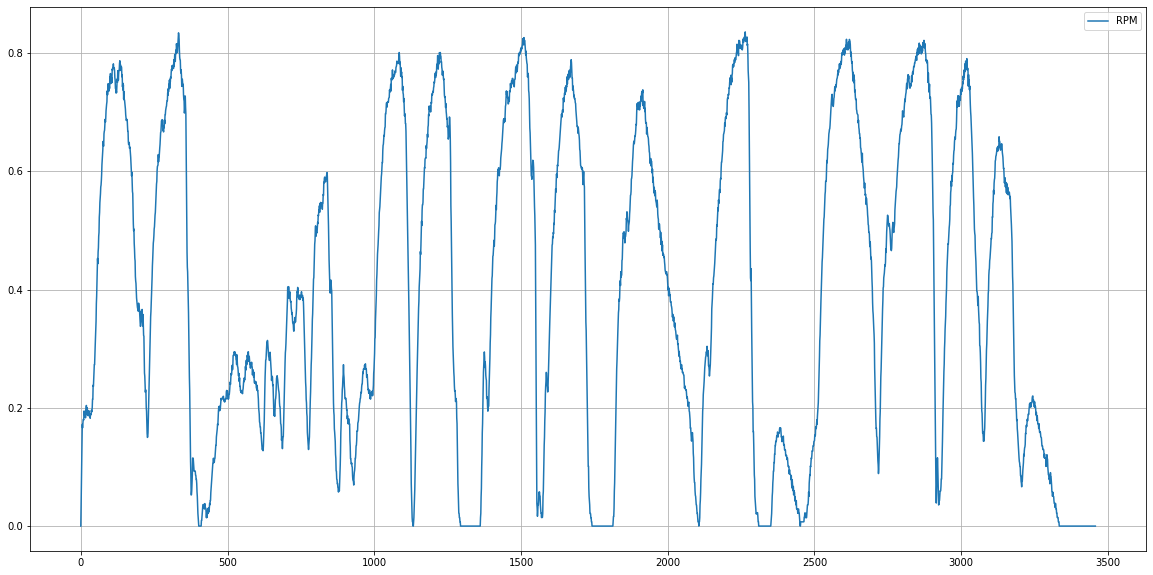

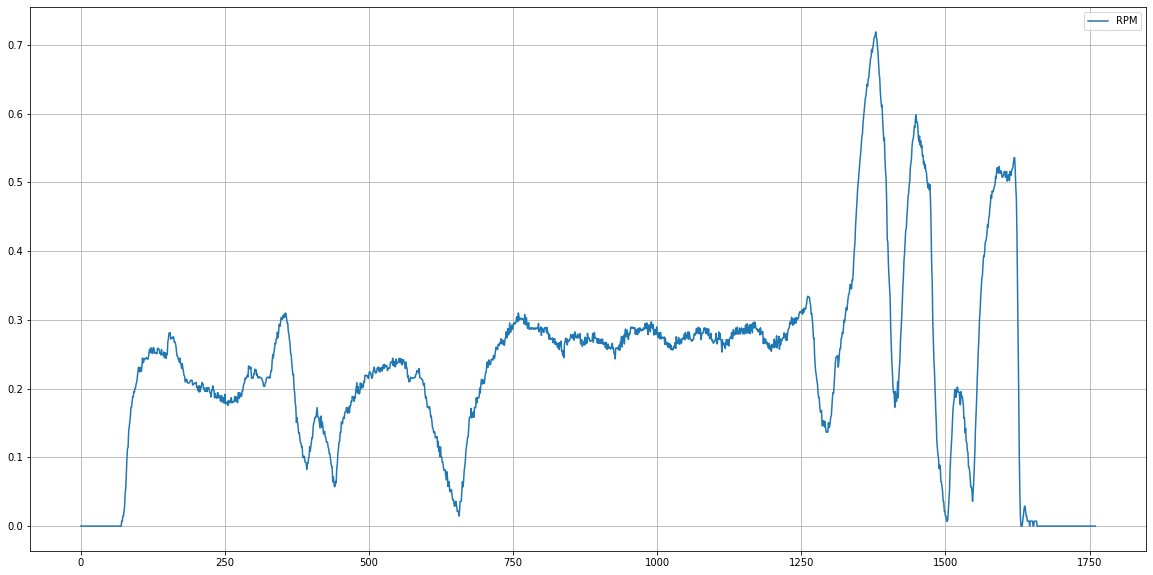

In [2]:
max_rpm = 15350

input_files = ("telemetry_highspeed.csv", "telemetry_lowspeed.csv", "telemetry_05.csv", "telemetry_06.csv")
csvs = []
period = 5
for file in input_files:
    csv = pd.read_csv(file)
    csv["motor_rpm"] = np.convolve(csv["motor_rpm"], np.ones((period,)) / period, mode='same')
    csvs += [csv]
    
for csv in csvs:    
    plt.figure(figsize=(20, 10))
    plt.grid()
    #plt.plot(csv["throttle_input"], label="throttle")
    #plt.plot(csv["steering_angle_input"], label="steering angle")
    plt.plot(csv["motor_rpm"] / max_rpm, label="RPM")
    plt.legend()
    plt.show()

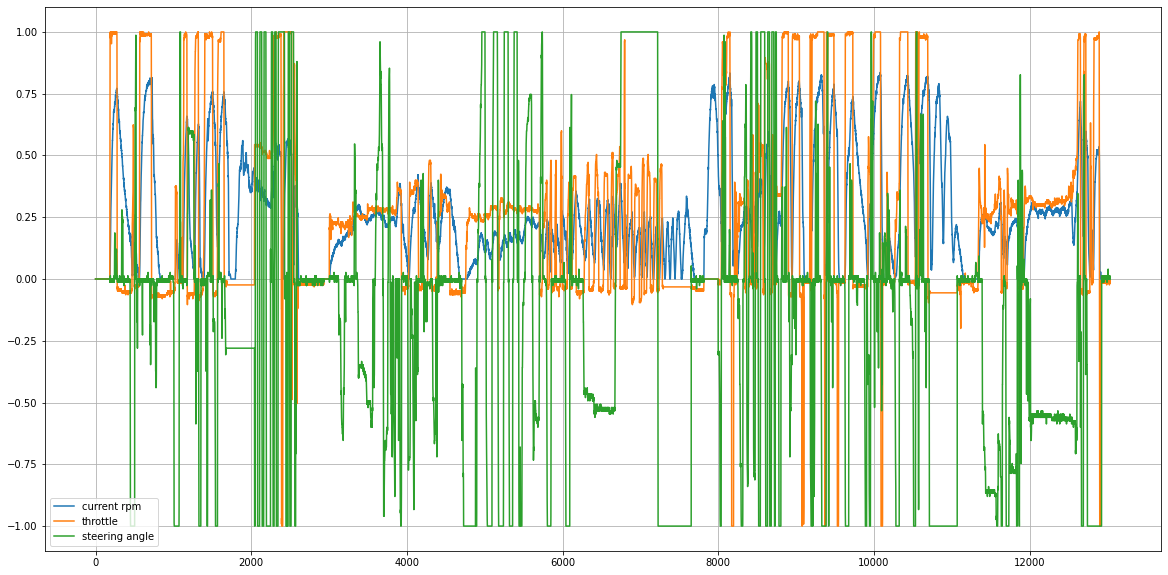

In [3]:
# I want the intput to be in the form of:
# (current RPM, throttle input, steering input, RPM change rate)

import numpy as np

data = np.array(np.zeros(4))

for csv in csvs:
    previous_rpm = 0
    for index, row in csv.iterrows():
        next_rpm = row["motor_rpm"] / max_rpm       
        previous_rpm = next_rpm
        
        record = [previous_rpm, row["throttle_input"], row["steering_angle_input"], next_rpm]
        
        data = np.vstack((data, record))

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data[:, 0], label="current rpm")
plt.plot(data[:, 1], label="throttle")
plt.plot(data[:, 2], label="steering angle")
plt.legend()
plt.show()

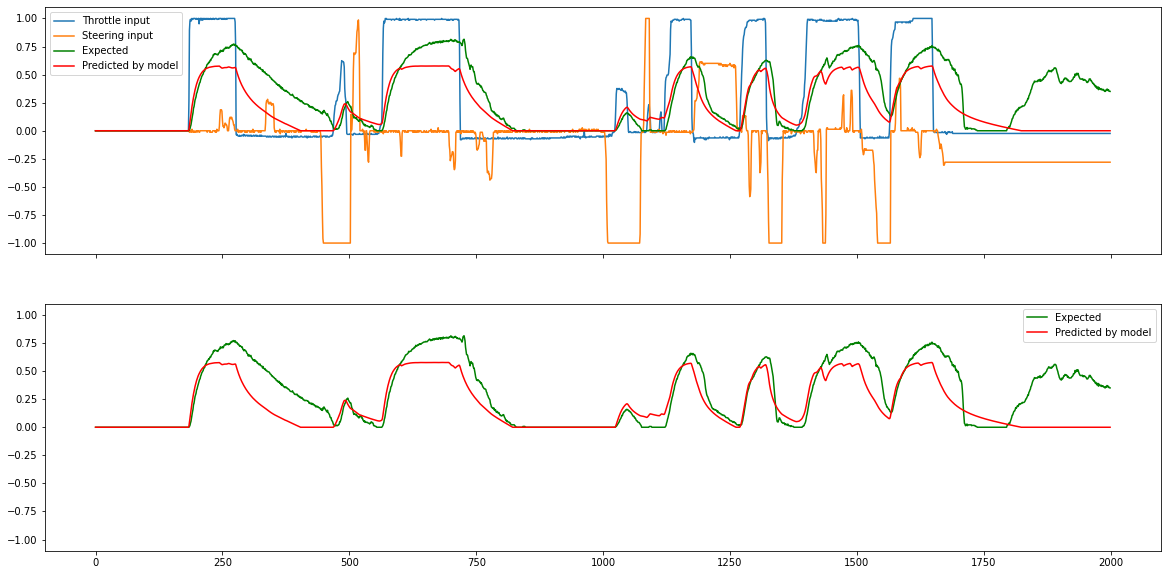

In [4]:
import math
max_rpm_normalized = 1.0

def torque(rpm, stall_torque):
    return stall_torque - (stall_torque / max_rpm_normalized) * rpm

def predict_torque(rpm, throttle, steering, x):
    drive_torque = torque(rpm, x[0]) * throttle
    load_torque = (rpm ** x[2]) * ((x[3] + x[4] * abs(steering)) ** x[5])

    return (drive_torque - load_torque) / x[1]

dt = 1./25.
steering_adjustment_step = 6.25 * dt
        
def predict_custom(offset, n, x):
    rpm = float(data[offset, 0])
    for row in data[offset:(offset + n)]:   
        motor_rpm_acc = predict_torque(rpm, row[1], row[2], x)        
        rpm = max(0, rpm + motor_rpm_acc * dt)
        yield rpm
        
o = 0
l = 2000
x = [800.0, 800.0, 2, 10.0, 5.0, 3.0]
predicted = np.array(list(predict_custom(o, l, x)))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))

ax0.plot(data[o:(o+l),1], label="Throttle input")
ax0.plot(data[o:(o+l),2], label="Steering input")
ax0.plot(data[o:(o+l),3], 'g', label="Expected")
ax0.plot(predicted, 'r', label="Predicted by model")
ax1.plot(data[o:(o+l),3], 'g', label="Expected")
ax1.plot(predicted, 'r', label="Predicted by model")
ax1.legend()
ax0.legend()
plt.show()


In [5]:
from scipy.optimize import minimize

def err(x):
    err = 0
    offset = 0
    for csv in csvs:
        predicted = predict_custom(offset, len(csv), x)
        offset += len(csv)
        for (pred, ref) in zip(predicted, data):
            err += (pred - ref[3]) ** 2
        return err

x0 = [800.0, 800.0, 2, 2.0, 2.0, 3.0]
bnds = ((0, 10000), (0, 10000), (0, 10000), (0, 10000), (0, 1000), (1, 2)) # positive numbers
res = minimize(err, x0, method='SLSQP', bounds=bnds).x

print(res)


[7.67241528e+02 8.32584604e+02 2.22692162e-03 3.63345136e+01
 3.41145822e+01 1.34423515e+00]


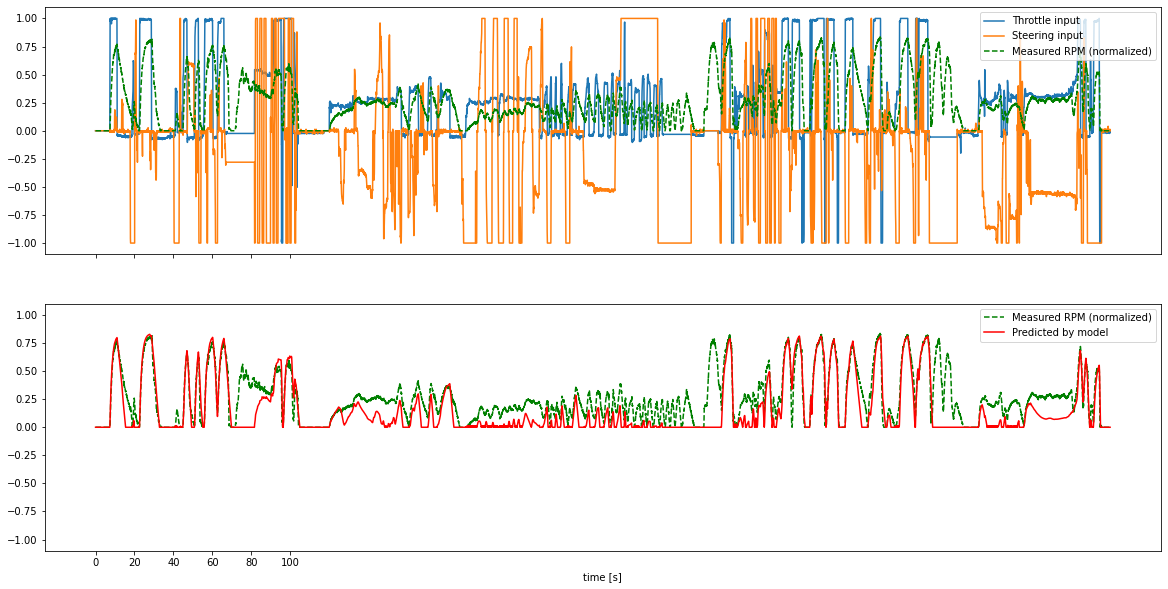

In [14]:
l = 30000
o = 0

predicted = np.array(list(predict_custom(o, l, res)))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))

ax0.plot(data[o:(o+l),1], label="Throttle input")
ax0.plot(data[o:(o+l),2], label="Steering input")
ax0.plot(data[o:(o+l),3], 'g--', label="Measured RPM (normalized)")
#ax0.plot(predicted, 'r', label="Predicted by model")
ax1.plot(data[o:(o+l),3], 'g--', label="Measured RPM (normalized)")
ax1.plot(predicted, 'r', label="Predicted by model")
ax1.legend()
ax0.legend()

plt.xlabel("time [s]")
plt.xticks([0, 500, 1000, 1500, 2000, 2500], [0, 20, 40, 60, 80, 100])

plt.show()

☝ in the graph above the most significant problem of this model is apparent - the model can't work with the direction of the rotation of the motor shaft, i.e. the model can't predict reversing.